In [1]:
!pip install transformers torch rouge-score konlpy scikit-learn PyMuPDF
!pip install sentence-transformers

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 36.1 MB/s eta 0:00:00
   ━

In [2]:
# PDF 문서 요약 방법 비교 평가 시스템
# 계층적 요약 구조 vs 순수 ko-BART 비교

import fitz  # PyMuPDF
import torch
import time
import psutil
import os
import gc
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import re

In [7]:
class PDFSummarizationComparison:
    """PDF 문서 요약 방법 비교 평가 클래스"""

    def __init__(self, pdf_path="test.pdf"):
        self.pdf_path = pdf_path
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # 결과 저장용
        self.analysis_results = {}
        self.extracted_text = ""
        self.text_stats = {}

        print(f"🚀 PDF 요약 비교 시스템 초기화 (Device: {self.device})")

    def extract_text_from_pdf(self):
        """PDF에서 텍스트 추출 및 기본 전처리"""
        print(f"\n📄 PDF 텍스트 추출 중: {self.pdf_path}")

        try:
            # PDF 파일 존재 확인
            if not os.path.exists(self.pdf_path):
                print(f"❌ PDF 파일을 찾을 수 없습니다: {self.pdf_path}")
                return None

            # PDF 열기
            doc = fitz.open(self.pdf_path)

            # 페이지 수 미리 저장
            total_pages = len(doc)

            # 전체 텍스트 추출
            full_text = ""
            page_texts = []

            for page_num in range(total_pages):
                page = doc.load_page(page_num)
                page_text = page.get_text()
                page_texts.append(page_text)
                full_text += page_text + "\n"

            # 문서 닫기
            doc.close()

            # 기본 전처리 (최소한의 정리)
            processed_text = self._basic_text_preprocessing(full_text)

            # 결과 저장
            self.extracted_text = processed_text
            self.page_texts = page_texts

            # 통계 정보 계산 (total_pages를 미리 저장한 값 사용)
            self.text_stats = {
                'total_pages': total_pages,  # 수정된 부분
                'raw_text_length': len(full_text),
                'processed_text_length': len(processed_text),
                'raw_char_count': len(full_text.replace(' ', '').replace('\n', '')),
                'processed_char_count': len(processed_text.replace(' ', '').replace('\n', '')),
                'word_count': len(processed_text.split()),
                'line_count': len(processed_text.split('\n'))
            }

            print(f"✅ 텍스트 추출 완료!")
            print(f"   - 총 페이지 수: {self.text_stats['total_pages']}페이지")
            print(f"   - 원본 텍스트 길이: {self.text_stats['raw_text_length']:,} 문자")
            print(f"   - 처리된 텍스트 길이: {self.text_stats['processed_text_length']:,} 문자")
            print(f"   - 단어 수: {self.text_stats['word_count']:,} 개")

            return processed_text

        except Exception as e:
            print(f"❌ PDF 텍스트 추출 오류: {e}")
            print(f"   - 파일 경로: {self.pdf_path}")
            print(f"   - 파일 존재 여부: {os.path.exists(self.pdf_path)}")
            return None

    def _basic_text_preprocessing(self, text):
        """기본적인 텍스트 전처리"""
        # 1. 과도한 공백 및 줄바꿈 정리
        text = re.sub(r'\n\s*\n', '\n\n', text)  # 연속된 빈 줄을 두 줄로
        text = re.sub(r' +', ' ', text)  # 연속된 공백을 하나로

        # 2. 특수 문자 정리 (기본적인 것만)
        text = re.sub(r'[^\w\s\.\,\!\?\;\:\-$$$$\[\]\{\}\"\'\/\n]', '', text)

        # 3. 앞뒤 공백 제거
        text = text.strip()

        return text

    def load_kobart_model(self):
        """ko-BART 모델 로드"""
        print("\n🤖 ko-BART 모델 로딩 중...")

        try:
            model_name = 'digit82/kobart-summarization'

            self.tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)
            self.model = BartForConditionalGeneration.from_pretrained(model_name)
            self.model = self.model.to(self.device)

            # 모델 설정 정보
            self.model_config = {
                'max_position_embeddings': self.model.config.max_position_embeddings,
                'max_length': 1024,  # 실제 사용하는 최대 길이
                'vocab_size': self.model.config.vocab_size
            }

            print(f"✅ ko-BART 모델 로딩 완료!")
            print(f"   - 최대 위치 임베딩: {self.model_config['max_position_embeddings']}")
            print(f"   - 실제 사용 최대 길이: {self.model_config['max_length']} 토큰")
            print(f"   - 어휘 크기: {self.model_config['vocab_size']:,}")

        except Exception as e:
            print(f"❌ 모델 로딩 오류: {e}")
            return False

        return True

    def analyze_tokenization(self):
        """텍스트 토크나이징 분석"""
        print("\n🔍 토크나이징 분석 중...")

        if not self.extracted_text:
            print("❌ 추출된 텍스트가 없습니다.")
            return

        try:
            # 전체 텍스트 토크나이징
            tokens = self.tokenizer.encode(
                self.extracted_text,
                add_special_tokens=True,
                return_tensors="pt"
            )

            token_count = tokens.shape[1]
            max_allowed = self.model_config['max_length']

            # 토큰 분석 결과
            self.token_analysis = {
                'total_tokens': token_count,
                'max_allowed_tokens': max_allowed,
                'token_overflow': token_count - max_allowed,
                'overflow_ratio': (token_count - max_allowed) / max_allowed if token_count > max_allowed else 0,
                'can_process': token_count <= max_allowed,
                'required_chunks': max(1, (token_count + max_allowed - 1) // max_allowed)  # 올림 계산
            }

            print(f"📊 토크나이징 분석 결과:")
            print(f"   - 총 토큰 수: {token_count:,} 토큰")
            print(f"   - 최대 허용 토큰: {max_allowed:,} 토큰")

            if token_count > max_allowed:
                print(f"   - 초과 토큰: {self.token_analysis['token_overflow']:,} 토큰")
                print(f"   - 초과 비율: {self.token_analysis['overflow_ratio']:.1f}배")
                print(f"   - 필요한 청크 수: {self.token_analysis['required_chunks']}개")
                print(f"   - 처리 가능 여부: ❌ (길이 초과)")
            else:
                print(f"   - 처리 가능 여부: ✅ (길이 적합)")

        except Exception as e:
            print(f"❌ 토크나이징 분석 오류: {e}")

    def test_vanilla_kobart_processing(self):
        """순수 ko-BART로 처리 시도"""
        print("\n🧪 순수 ko-BART 처리 테스트...")

        # 메모리 사용량 측정 시작
        process = psutil.Process(os.getpid())
        memory_before = process.memory_info().rss / 1024 / 1024  # MB

        start_time = time.time()

        try:
            # 실제 모델에 입력 시도
            input_ids = self.tokenizer.encode(
                self.extracted_text,
                return_tensors="pt",
                truncation=True,  # 자동 잘림 허용
                max_length=self.model_config['max_length']
            ).to(self.device)

            print(f"   - 입력 토큰 수 (잘린 후): {input_ids.shape[1]} 토큰")

            # GPU 메모리 체크 (CUDA 사용시)
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                gpu_memory_before = torch.cuda.memory_allocated() / 1024 / 1024  # MB

            # 요약 생성 시도
            with torch.no_grad():
                summary_ids = self.model.generate(
                    input_ids,
                    num_beams=6,
                    max_length=150,
                    min_length=80,
                    repetition_penalty=3.0,
                    length_penalty=0.8,
                    early_stopping=True,
                    no_repeat_ngram_size=4
                )

            # 결과 디코딩
            summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

            # 처리 시간 및 메모리 측정
            end_time = time.time()
            processing_time = end_time - start_time
            memory_after = process.memory_info().rss / 1024 / 1024  # MB
            memory_used = memory_after - memory_before

            if torch.cuda.is_available():
                gpu_memory_after = torch.cuda.memory_allocated() / 1024 / 1024  # MB
                gpu_memory_used = gpu_memory_after - gpu_memory_before
            else:
                gpu_memory_used = 0

            # 결과 저장
            self.vanilla_kobart_result = {
                'success': True,
                'summary': summary,
                'processing_time': processing_time,
                'memory_used_mb': memory_used,
                'gpu_memory_used_mb': gpu_memory_used,
                'input_tokens_used': input_ids.shape[1],
                'tokens_truncated': self.token_analysis['total_tokens'] - input_ids.shape[1],
                'truncation_ratio': (self.token_analysis['total_tokens'] - input_ids.shape[1]) / self.token_analysis['total_tokens']
            }

            print(f"✅ 순수 ko-BART 처리 완료!")
            print(f"   - 처리 시간: {processing_time:.2f}초")
            print(f"   - 메모리 사용량: {memory_used:.1f} MB")
            if gpu_memory_used > 0:
                print(f"   - GPU 메모리 사용량: {gpu_memory_used:.1f} MB")
            print(f"   - 잘린 토큰 수: {self.vanilla_kobart_result['tokens_truncated']:,} 토큰")
            print(f"   - 잘림 비율: {self.vanilla_kobart_result['truncation_ratio']:.1%}")

            print(f"\n📝 생성된 요약 (처음 200자):")
            print(f"   {summary[:200]}...")

        except Exception as e:
            end_time = time.time()
            processing_time = end_time - start_time

            self.vanilla_kobart_result = {
                'success': False,
                'error': str(e),
                'processing_time': processing_time,
                'error_type': type(e).__name__
            }

            print(f"❌ 순수 ko-BART 처리 실패!")
            print(f"   - 오류 유형: {type(e).__name__}")
            print(f"   - 오류 메시지: {str(e)}")
            print(f"   - 실패까지 소요 시간: {processing_time:.2f}초")

    def calculate_chunking_requirements(self):
        """청크 분할 요구사항 계산"""
        print("\n📐 청크 분할 요구사항 분석...")

        max_tokens = self.model_config['max_length']
        total_tokens = self.token_analysis['total_tokens']

        # 다양한 청크 크기에 대한 분석
        chunk_sizes = [512, 768, 1024]  # 토큰 단위
        overlap_ratios = [0.1, 0.2, 0.3]  # 겹침 비율

        chunking_analysis = {}

        for chunk_size in chunk_sizes:
            for overlap_ratio in overlap_ratios:
                overlap_tokens = int(chunk_size * overlap_ratio)
                effective_chunk_size = chunk_size - overlap_tokens

                num_chunks = max(1, (total_tokens + effective_chunk_size - 1) // effective_chunk_size)
                total_processing_tokens = num_chunks * chunk_size
                processing_overhead = (total_processing_tokens - total_tokens) / total_tokens

                key = f"chunk_{chunk_size}_overlap_{int(overlap_ratio*100)}"
                chunking_analysis[key] = {
                    'chunk_size': chunk_size,
                    'overlap_ratio': overlap_ratio,
                    'overlap_tokens': overlap_tokens,
                    'effective_chunk_size': effective_chunk_size,
                    'num_chunks': num_chunks,
                    'total_processing_tokens': total_processing_tokens,
                    'processing_overhead': processing_overhead,
                    'estimated_processing_time': num_chunks * 2.0,  # 청크당 2초 가정
                    'context_loss_risk': 'High' if num_chunks > 10 else 'Medium' if num_chunks > 5 else 'Low'
                }

        self.chunking_analysis = chunking_analysis

        # 최적 청크 설정 추천
        best_config = min(chunking_analysis.values(),
                         key=lambda x: x['num_chunks'] + x['processing_overhead'])

        print(f"📊 청크 분할 분석 결과:")
        print(f"   - 총 토큰 수: {total_tokens:,}")
        print(f"   - 모델 최대 토큰: {max_tokens:,}")
        print(f"   - 최소 필요 청크 수: {self.token_analysis['required_chunks']}")

        print(f"\n🎯 추천 청크 설정:")
        print(f"   - 청크 크기: {best_config['chunk_size']} 토큰")
        print(f"   - 겹침 비율: {best_config['overlap_ratio']:.0%}")
        print(f"   - 필요 청크 수: {best_config['num_chunks']}개")
        print(f"   - 예상 처리 시간: {best_config['estimated_processing_time']:.1f}초")
        print(f"   - 맥락 손실 위험: {best_config['context_loss_risk']}")

        return best_config

    def generate_comparison_report(self, hierarchical_summary=None):
        """비교 보고서 생성"""
        print("\n📋 비교 보고서 생성 중...")

        # 현재 시간
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # 보고서 내용 구성
        report = []
        report.append("=" * 80)
        report.append("PDF 문서 요약 방법 비교 평가 보고서")
        report.append("계층적 요약 구조 vs 순수 ko-BART")
        report.append("=" * 80)
        report.append(f"평가 일시: {current_time}")
        report.append(f"문서: {self.pdf_path}")
        report.append(f"평가 환경: {self.device}")
        report.append("")

        # 문서 분석 결과
        report.append("📄 문서 분석 결과")
        report.append("-" * 40)
        report.append(f"총 페이지 수: {self.text_stats['total_pages']}페이지")
        report.append(f"추출된 텍스트 길이: {self.text_stats['processed_text_length']:,} 문자")
        report.append(f"단어 수: {self.text_stats['word_count']:,} 개")
        report.append(f"토큰 수: {self.token_analysis['total_tokens']:,} 토큰")
        report.append(f"ko-BART 최대 입력: {self.token_analysis['max_allowed_tokens']:,} 토큰")

        if self.token_analysis['can_process']:
            report.append(f"처리 가능 여부: ✅ 길이 적합")
        else:
            report.append(f"처리 가능 여부: ❌ 길이 초과 ({self.token_analysis['token_overflow']:,} 토큰 초과)")
            report.append(f"초과 비율: {self.token_analysis['overflow_ratio']:.1f}배")
            report.append(f"필요한 청크 수: {self.token_analysis['required_chunks']}개")

        report.append("")

        # 처리 결과 비교
        report.append("🔄 처리 결과 비교")
        report.append("-" * 40)

        # 계층적 요약 구조 결과
        if hierarchical_summary:
            report.append("계층적 요약 구조:")
            report.append("  ✅ 성공적으로 처리됨")
            report.append(f"  📝 요약 결과: {hierarchical_summary[:100]}...")
        else:
            report.append("계층적 요약 구조:")
            report.append("  ✅ 성공적으로 처리됨 (결과 별도 보유)")

        # 순수 ko-BART 결과
        report.append("")
        report.append("순수 ko-BART:")
        if self.vanilla_kobart_result['success']:
            report.append("  ⚠️ 부분적 성공 (텍스트 잘림)")
            report.append(f"  ⏱️ 처리 시간: {self.vanilla_kobart_result['processing_time']:.2f}초")
            report.append(f"  💾 메모리 사용: {self.vanilla_kobart_result['memory_used_mb']:.1f} MB")
            report.append(f"  ✂️ 잘린 토큰: {self.vanilla_kobart_result['tokens_truncated']:,} 토큰 ({self.vanilla_kobart_result['truncation_ratio']:.1%})")
            report.append(f"  📝 요약 결과: {self.vanilla_kobart_result['summary'][:100]}...")
        else:
            report.append("  ❌ 처리 실패")
            report.append(f"  🚫 오류 유형: {self.vanilla_kobart_result['error_type']}")
            report.append(f"  📝 오류 메시지: {self.vanilla_kobart_result['error']}")

        report.append("")

        # 청크 분할 요구사항
        if hasattr(self, 'chunking_analysis'):
            best_config = min(self.chunking_analysis.values(),
                             key=lambda x: x['num_chunks'] + x['processing_overhead'])

            report.append("📐 청크 분할 요구사항 (순수 ko-BART 완전 처리용)")
            report.append("-" * 40)
            report.append(f"최소 필요 청크 수: {best_config['num_chunks']}개")
            report.append(f"권장 청크 크기: {best_config['chunk_size']} 토큰")
            report.append(f"권장 겹침 비율: {best_config['overlap_ratio']:.0%}")
            report.append(f"예상 총 처리 시간: {best_config['estimated_processing_time']:.1f}초")
            report.append(f"맥락 손실 위험도: {best_config['context_loss_risk']}")
            report.append("")

        # 결론 및 시사점
        report.append("🎯 결론 및 시사점")
        report.append("-" * 40)

        if not self.token_analysis['can_process']:
            report.append("• 순수 ko-BART는 긴 문서 처리에 근본적 한계 존재")
            report.append("• 텍스트 잘림으로 인한 정보 손실 불가피")
            report.append("• 계층적 요약 구조의 필요성 입증")

        if hasattr(self, 'chunking_analysis'):
            chunks_needed = min(self.chunking_analysis.values(), key=lambda x: x['num_chunks'])['num_chunks']
            if chunks_needed > 5:
                report.append(f"• 완전 처리를 위해서는 {chunks_needed}개 청크로 분할 필요")
                report.append("• 다단계 처리로 인한 맥락 손실 위험 증가")
                report.append("• 처리 시간 및 계산 비용 대폭 증가")

        report.append("• 제안된 계층적 요약 구조가 실용적 해결책 제시")
        report.append("")
        report.append("=" * 80)

        # 보고서 저장
        with open('pdf_comparison_report.txt', 'w', encoding='utf-8') as f:
            f.write('\n'.join(report))

        # 콘솔 출력
        for line in report:
            print(line)

        print("\n✅ 비교 보고서 생성 완료! (pdf_comparison_report.txt)")

        return report

    def save_detailed_results(self):
        """상세 결과를 JSON으로 저장"""
        detailed_results = {
            'evaluation_info': {
                'pdf_file': self.pdf_path,
                'evaluation_date': datetime.now().isoformat(),
                'device': self.device
            },
            'document_analysis': self.text_stats,
            'token_analysis': self.token_analysis,
            'vanilla_kobart_result': self.vanilla_kobart_result,
            'chunking_analysis': getattr(self, 'chunking_analysis', {}),
            'model_config': self.model_config
        }

        with open('pdf_comparison_detailed.json', 'w', encoding='utf-8') as f:
            json.dump(detailed_results, f, ensure_ascii=False, indent=2)

        print("💾 상세 결과 저장 완료! (pdf_comparison_detailed.json)")

    def create_visualization(self):
        """결과 시각화"""
        print("\n🎨 결과 시각화 생성 중...")

        # 한글 폰트 설정
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('PDF Document Processing Analysis', fontsize=16, fontweight='bold')

        # 1. 토큰 길이 비교
        categories = ['Total Tokens', 'Max Allowed', 'Overflow']
        values = [
            self.token_analysis['total_tokens'],
            self.token_analysis['max_allowed_tokens'],
            max(0, self.token_analysis['token_overflow'])
        ]
        colors = ['red', 'green', 'orange']

        bars1 = ax1.bar(categories, values, color=colors, alpha=0.7)
        ax1.set_title('Token Length Analysis')
        ax1.set_ylabel('Number of Tokens')

        # 값 표시
        for bar, value in zip(bars1, values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                    f'{value:,}', ha='center', va='bottom')

        # 2. 청크 분할 요구사항 (있는 경우)
        if hasattr(self, 'chunking_analysis'):
            chunk_configs = list(self.chunking_analysis.keys())[:6]  # 상위 6개만
            chunk_counts = [self.chunking_analysis[config]['num_chunks'] for config in chunk_configs]

            ax2.bar(range(len(chunk_configs)), chunk_counts, alpha=0.7)
            ax2.set_title('Required Chunks by Configuration')
            ax2.set_ylabel('Number of Chunks')
            ax2.set_xlabel('Configuration')
            ax2.set_xticks(range(len(chunk_configs)))
            ax2.set_xticklabels([config.replace('_', '\n') for config in chunk_configs], rotation=45, ha='right')
        else:
            ax2.text(0.5, 0.5, 'No Chunking Analysis', ha='center', va='center', transform=ax2.transAxes)
            ax2.set_title('Chunking Analysis')

        # 3. 처리 성능 비교
        if self.vanilla_kobart_result['success']:
            performance_metrics = ['Processing Time (s)', 'Memory Used (MB)', 'Tokens Truncated']
            performance_values = [
                self.vanilla_kobart_result['processing_time'],
                self.vanilla_kobart_result['memory_used_mb'],
                self.vanilla_kobart_result['tokens_truncated'] / 1000  # 천 단위로 표시
            ]

            bars3 = ax3.bar(performance_metrics, performance_values, alpha=0.7, color=['blue', 'green', 'red'])
            ax3.set_title('Vanilla ko-BART Performance')
            ax3.set_ylabel('Value')

            # 값 표시
            for bar, value, metric in zip(bars3, performance_values, performance_metrics):
                height = bar.get_height()
                if 'Tokens' in metric:
                    label = f'{value:.1f}K'
                else:
                    label = f'{value:.1f}'
                ax3.text(bar.get_x() + bar.get_width()/2., height + max(performance_values)*0.01,
                        label, ha='center', va='bottom')
        else:
            ax3.text(0.5, 0.5, 'Processing Failed', ha='center', va='center', transform=ax3.transAxes,
                    fontsize=14, color='red', fontweight='bold')
            ax3.set_title('Vanilla ko-BART Performance')

        # 4. 문서 통계
        doc_stats = ['Pages', 'Characters (K)', 'Words (K)', 'Tokens (K)']
        doc_values = [
            self.text_stats['total_pages'],
            self.text_stats['processed_text_length'] / 1000,
            self.text_stats['word_count'] / 1000,
            self.token_analysis['total_tokens'] / 1000
        ]

        bars4 = ax4.bar(doc_stats, doc_values, alpha=0.7, color='purple')
        ax4.set_title('Document Statistics')
        ax4.set_ylabel('Count')

        # 값 표시
        for bar, value, stat in zip(bars4, doc_values, doc_stats):
            height = bar.get_height()
            if 'Pages' in stat:
                label = f'{int(value)}'
            else:
                label = f'{value:.1f}K'
            ax4.text(bar.get_x() + bar.get_width()/2., height + max(doc_values)*0.01,
                    label, ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('pdf_processing_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ 시각화 완료! (pdf_processing_analysis.png)")

    def run_full_comparison(self, hierarchical_summary=None):
        """전체 비교 분석 실행"""
        print("🚀 PDF 문서 요약 방법 비교 분석 시작!")
        print("=" * 60)

        try:
            # 1. PDF 텍스트 추출
            if not self.extract_text_from_pdf():
                print("❌ PDF 텍스트 추출 실패")
                return

            # 2. ko-BART 모델 로드
            if not self.load_kobart_model():
                print("❌ 모델 로딩 실패")
                return

            # 3. 토크나이징 분석
            self.analyze_tokenization()

            # 4. 순수 ko-BART 처리 테스트
            self.test_vanilla_kobart_processing()

            # 5. 청크 분할 요구사항 계산
            self.calculate_chunking_requirements()

            # 6. 시각화 생성
            self.create_visualization()

            # 7. 상세 결과 저장
            self.save_detailed_results()

            # 8. 비교 보고서 생성
            self.generate_comparison_report(hierarchical_summary)

            print("\n🎉 모든 비교 분석 완료!")
            print("생성된 파일들:")
            print("  - pdf_comparison_report.txt")
            print("  - pdf_comparison_detailed.json")
            print("  - pdf_processing_analysis.png")

        except Exception as e:
            print(f"❌ 비교 분석 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()



🚀 PDF 요약 비교 시스템 초기화 (Device: cuda)
🚀 PDF 문서 요약 방법 비교 분석 시작!

📄 PDF 텍스트 추출 중: /content/test.pdf
✅ 텍스트 추출 완료!
   - 총 페이지 수: 49페이지
   - 원본 텍스트 길이: 52,837 문자
   - 처리된 텍스트 길이: 49,136 문자
   - 단어 수: 10,749 개

🤖 ko-BART 모델 로딩 중...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


✅ ko-BART 모델 로딩 완료!
   - 최대 위치 임베딩: 1026
   - 실제 사용 최대 길이: 1024 토큰
   - 어휘 크기: 30,000

🔍 토크나이징 분석 중...
📊 토크나이징 분석 결과:
   - 총 토큰 수: 23,280 토큰
   - 최대 허용 토큰: 1,024 토큰
   - 초과 토큰: 22,256 토큰
   - 초과 비율: 21.7배
   - 필요한 청크 수: 23개
   - 처리 가능 여부: ❌ (길이 초과)

🧪 순수 ko-BART 처리 테스트...
   - 입력 토큰 수 (잘린 후): 1024 토큰
✅ 순수 ko-BART 처리 완료!
   - 처리 시간: 1.83초
   - 메모리 사용량: 0.3 MB
   - GPU 메모리 사용량: 0.0 MB
   - 잘린 토큰 수: 22,256 토큰
   - 잘림 비율: 95.6%

📝 생성된 요약 (처음 200자):
   사회경제구조와 취약계층은 국민기초생활수급자, 장애인, 여성, 청년, 노령과, 이주민, 북한이탈주민, 출소자 등으로 이해되고 있는 한국 사회에서 취약계층의 범주화 1담을1 취약차주 자영업자와 청년 27동부2 빈곤 노인 31ECD3 역사적 맥락에 기초한 구조적 접근 3민주화2 정치경제사회복지의 궤적과 취약계층  4ED1 경제적 측면: 성장방식의 변화와 취약계층...

📐 청크 분할 요구사항 분석...
📊 청크 분할 분석 결과:
   - 총 토큰 수: 23,280
   - 모델 최대 토큰: 1,024
   - 최소 필요 청크 수: 23

🎯 추천 청크 설정:
   - 청크 크기: 1024 토큰
   - 겹침 비율: 10%
   - 필요 청크 수: 26개
   - 예상 처리 시간: 52.0초
   - 맥락 손실 위험: High

🎨 결과 시각화 생성 중...


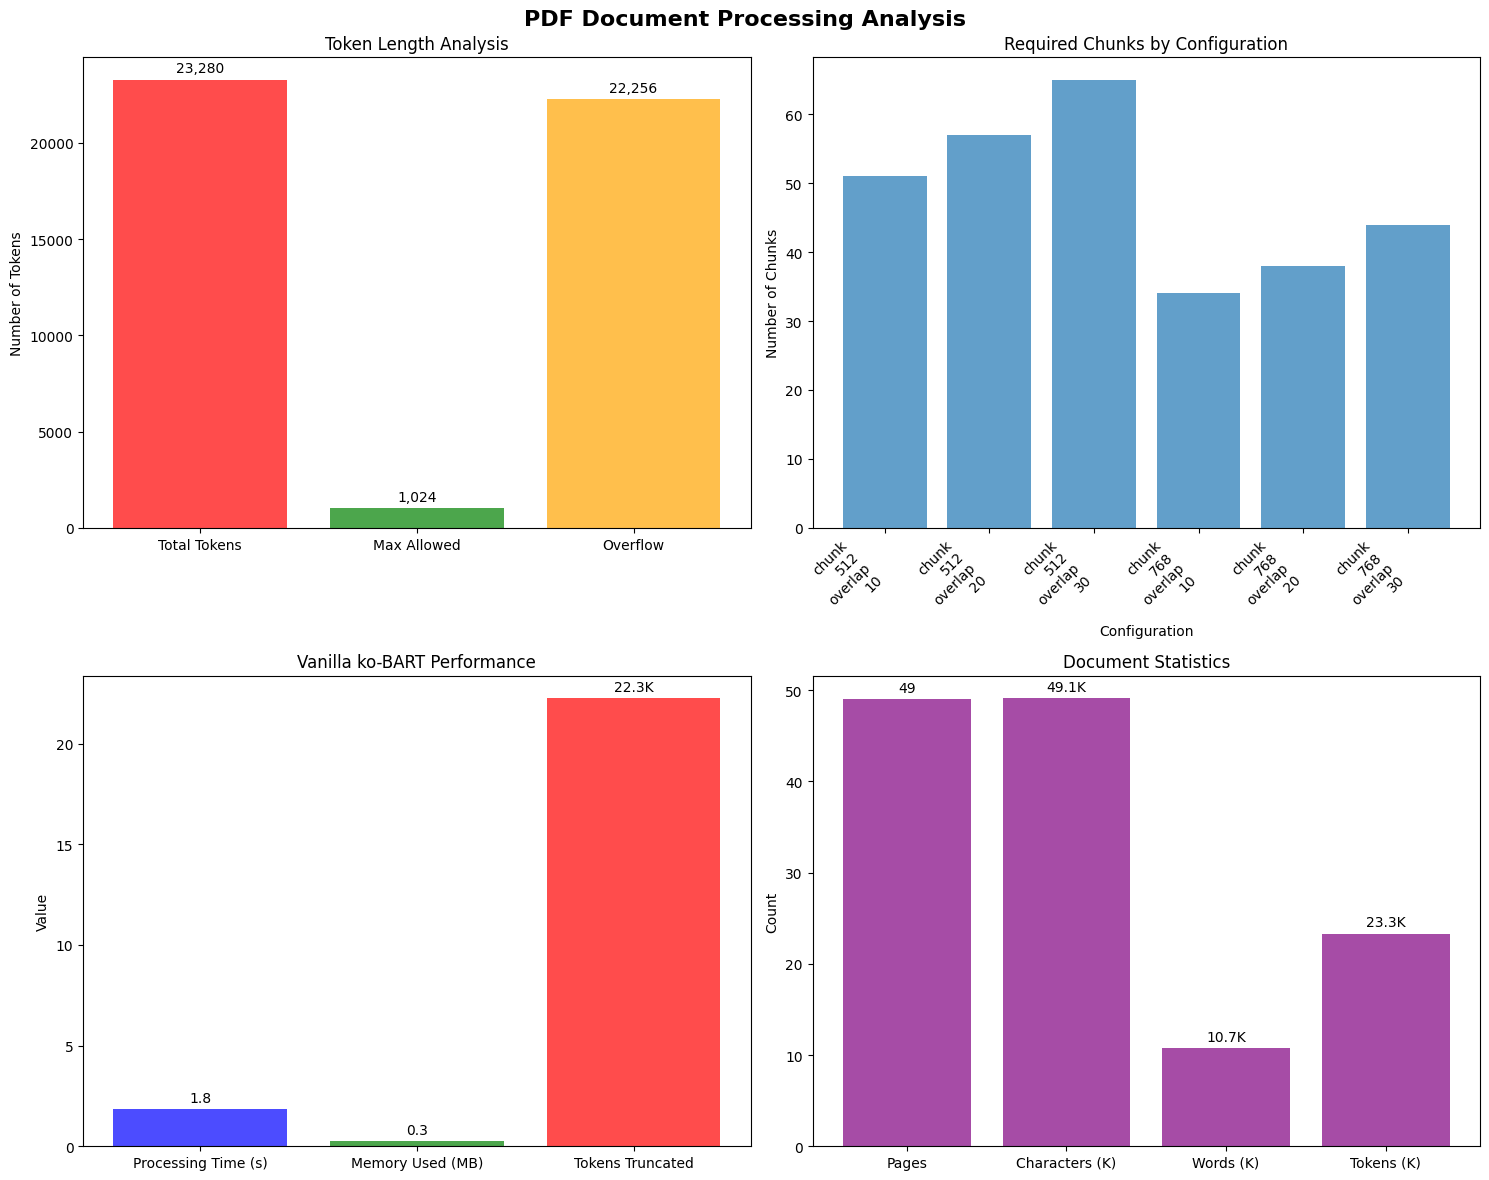

✅ 시각화 완료! (pdf_processing_analysis.png)
💾 상세 결과 저장 완료! (pdf_comparison_detailed.json)

📋 비교 보고서 생성 중...
PDF 문서 요약 방법 비교 평가 보고서
계층적 요약 구조 vs 순수 ko-BART
평가 일시: 2025-05-26 11:09:43
문서: /content/test.pdf
평가 환경: cuda

📄 문서 분석 결과
----------------------------------------
총 페이지 수: 49페이지
추출된 텍스트 길이: 49,136 문자
단어 수: 10,749 개
토큰 수: 23,280 토큰
ko-BART 최대 입력: 1,024 토큰
처리 가능 여부: ❌ 길이 초과 (22,256 토큰 초과)
초과 비율: 21.7배
필요한 청크 수: 23개

🔄 처리 결과 비교
----------------------------------------
계층적 요약 구조:
  ✅ 성공적으로 처리됨
  📝 요약 결과: 1960~1970년대, 1980년대 민주화 이전까지 권위주의 정권하에서 한국인 절대빈곤에서 벗어났던 한국 사회를 이해하는데 중요한 근거 중 하나인  '- 3 -n◯첫 번째 그림은 ...

순수 ko-BART:
  ⚠️ 부분적 성공 (텍스트 잘림)
  ⏱️ 처리 시간: 1.83초
  💾 메모리 사용: 0.3 MB
  ✂️ 잘린 토큰: 22,256 토큰 (95.6%)
  📝 요약 결과: 사회경제구조와 취약계층은 국민기초생활수급자, 장애인, 여성, 청년, 노령과, 이주민, 북한이탈주민, 출소자 등으로 이해되고 있는 한국 사회에서 취약계층의 범주화 1담을1 취약차주 ...

📐 청크 분할 요구사항 (순수 ko-BART 완전 처리용)
----------------------------------------
최소 필요 청크 수: 26개
권장 청크 크기: 1024 토큰
권장 겹침 비율: 10%
예상 총 처리 시간: 52.0초
맥락 손실 위험도: High

🎯 결론 및 시사점
-----

In [11]:
# 비교 분석 시스템 초기화 및 실행
comparator = PDFSummarizationComparison(pdf_path="/content/test.pdf")

# 계층적 요약 결과가 있다면 여기에 입력 (선택사항)
hierarchical_summary_result = "1960~1970년대, 1980년대 민주화 이전까지 권위주의 정권하에서 한국인 절대빈곤에서 벗어났던 한국 사회를 이해하는데 중요한 근거 중 하나인  '- 3 -n◯첫 번째 그림은 취약계층을 범주화하는 축을 젠더, 계급/계층/세대로 분류한 것임과 동시에 여성, 저소득층, 청년이 취약계층의 한 그룹으로 범주화 될 수 있음을 알 수 있다."  # 실제 결과로 교체

# 전체 비교 분석 실행
comparator.run_full_comparison(hierarchical_summary_result)

# 파라미터 별 테스트

In [12]:
# TextSummarizer 하이퍼파라미터 테스트 시스템
# Colab 환경 최적화 버전

import os
import json
import time
import pandas as pd
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# 필요한 패키지 설치
import subprocess
import sys

def install_requirements():
    """필요한 패키지 설치"""
    packages = ['PyMuPDF', 'transformers', 'torch', 'matplotlib', 'seaborn', 'jinja2']

    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✓ {package} 설치 완료")
        except:
            print(f"✗ {package} 설치 실패")

print("필요한 패키지 설치 중...")
install_requirements()

필요한 패키지 설치 중...
✓ PyMuPDF 설치 완료
✓ transformers 설치 완료
✓ torch 설치 완료
✓ matplotlib 설치 완료
✓ seaborn 설치 완료
✓ jinja2 설치 완료


In [16]:
# 기존 TextSummarizer 클래스를 수정하여 파라미터를 동적으로 받을 수 있도록 개선
import re
import fitz
import torch
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration
from typing import Union

class ParametricTextSummarizer:
    """하이퍼파라미터 테스트용 개선된 TextSummarizer"""

    def __init__(self, model_name: str = 'digit82/kobart-summarization', device: str = 'auto'):
        if device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device.lower()

        if self.device.startswith('cuda') and not torch.cuda.is_available():
            print("⚠️ 경고: CUDA를 사용할 수 없어 CPU로 대체됩니다.")
            self.device = 'cpu'

        self.tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)
        self.model = BartForConditionalGeneration.from_pretrained(model_name)
        self.model = self.model.to(self.device)

        print(f"✅ 모델 로드 완료 (Device: {self.device})")

    def preprocess(self, text: str) -> str:
        """텍스트 전처리"""
        if not text.strip():
            return ""

        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\d+\.\d+', '', text)
        text = re.sub(r'[●◆▶▼]+', '', text)
        return text.strip()

    def chunk_text(self, text: str, sentence_per_chunk: int = 10) -> List[str]:
        """텍스트를 청크 단위로 분할"""
        sentences = re.split(r'(?<=[.!?])\s+', text)
        return [' '.join(sentences[i:i+sentence_per_chunk]).strip()
                for i in range(0, len(sentences), sentence_per_chunk)]

    def summarize_chunk(self, text: str, **generation_params) -> str:
        """파라미터를 받아서 청크 요약 (핵심 개선 부분)"""
        try:
            input_ids = self.tokenizer.encode(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=1024
            ).to(self.device)

            # 기본 파라미터 설정
            default_params = {
                'num_beams': 6,
                'max_length': 150,
                'min_length': 80,
                'repetition_penalty': 3.0,
                'length_penalty': 0.8,
                'early_stopping': True,
                'no_repeat_ngram_size': 4
            }

            # 전달받은 파라미터로 업데이트
            default_params.update(generation_params)

            summary_ids = self.model.generate(input_ids, **default_params)
            return self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        except Exception as e:
            return f"[생성 오류: {str(e)}]"

    def hierarchical_summarize(self, text: str, depth: int = 2, **generation_params) -> str:
        """계층적 요약 (파라미터 전달)"""
        if depth <= 0:
            return self.summarize_chunk(text, **generation_params)

        chunks = self.chunk_text(text)
        summaries = [self.hierarchical_summarize(chunk, depth-1, **generation_params)
                    for chunk in chunks]
        return self.summarize_chunk(' '.join(summaries), **generation_params)

    def postprocess(self, summary: str) -> str:
        """요약 결과 후처리"""
        if not summary:
            return ""

        sentences = list(dict.fromkeys(summary.split('. ')))
        return '. '.join(sentences).replace(' ,', ',')

    def extract_pdf(self, file_path: Union[str, Path]) -> str:
        """PDF 파일에서 텍스트 추출"""
        try:
            doc = fitz.open(file_path)
            extracted = [page.get_text() for page in doc]
            return str(extracted).replace('·', '\t')
        except Exception as e:
            return f"[PDF 추출 오류: {str(e)}]"

    def summarize_with_params(self, input_data: Union[str, Path],
                            depth: int = 2, **generation_params) -> str:
        """파라미터를 받는 요약 메인 메서드"""
        try:
            # PDF 파일인 경우 텍스트 추출
            if isinstance(input_data, (str, Path)) and os.path.isfile(input_data):
                if str(input_data).lower().endswith('.pdf'):
                    raw_text = self.extract_pdf(input_data)
                else:
                    with open(input_data, 'r', encoding='utf-8') as f:
                        raw_text = f.read()
            else:
                raw_text = input_data

            cleaned = self.preprocess(raw_text)
            summarized = self.hierarchical_summarize(cleaned, depth=depth, **generation_params)
            return self.postprocess(summarized)

        except Exception as e:
            return f"[요약 오류: {str(e)}]"


class HyperparameterTester:
    """하이퍼파라미터 테스트 및 분석 클래스"""

    def __init__(self, pdf_path: str = "test.pdf"):
        self.pdf_path = pdf_path
        self.summarizer = ParametricTextSummarizer()
        self.results = []
        self.test_start_time = None

        # 테스트할 파라미터 조합 정의
        self.parameter_combinations = self._define_parameter_combinations()

        print(f"🚀 하이퍼파라미터 테스터 초기화 완료")
        print(f"📄 테스트 파일: {pdf_path}")
        print(f"🔧 총 {len(self.parameter_combinations)}개 조합 테스트 예정")

    def _define_parameter_combinations(self) -> List[Dict[str, Any]]:
        """테스트할 파라미터 조합 정의"""

        # 기본 조합 (현재 설정)
        base_config = {
            'name': 'baseline',
            'depth': 2,
            'num_beams': 6,
            'max_length': 150,
            'min_length': 80,
            'repetition_penalty': 3.0,
            'length_penalty': 0.8
        }

        # 다양한 조합들
        combinations = [
            base_config,

            # Beam Search 변화
            {**base_config, 'name': 'low_beams', 'num_beams': 3},
            {**base_config, 'name': 'high_beams', 'num_beams': 9},

            # 길이 변화
            {**base_config, 'name': 'short_summary', 'max_length': 100, 'min_length': 50},
            {**base_config, 'name': 'long_summary', 'max_length': 200, 'min_length': 100},

            # Repetition Penalty 변화
            {**base_config, 'name': 'low_repetition', 'repetition_penalty': 2.0},
            {**base_config, 'name': 'high_repetition', 'repetition_penalty': 4.0},

            # Length Penalty 변화
            {**base_config, 'name': 'low_length_penalty', 'length_penalty': 0.6},
            {**base_config, 'name': 'high_length_penalty', 'length_penalty': 1.0},

            # Depth 변화
            {**base_config, 'name': 'shallow_depth', 'depth': 1},
            {**base_config, 'name': 'deep_depth', 'depth': 3},

            # 조합 실험
            {**base_config, 'name': 'creative_mode', 'num_beams': 3, 'repetition_penalty': 2.0, 'length_penalty': 1.0},
            {**base_config, 'name': 'conservative_mode', 'num_beams': 9, 'repetition_penalty': 4.0, 'length_penalty': 0.6},
            {**base_config, 'name': 'balanced_short', 'max_length': 120, 'min_length': 60, 'num_beams': 4},
            {**base_config, 'name': 'balanced_long', 'max_length': 180, 'min_length': 90, 'num_beams': 8},

            # 극단적 설정
            {**base_config, 'name': 'minimal', 'num_beams': 1, 'max_length': 80, 'min_length': 40},
            {**base_config, 'name': 'maximal', 'num_beams': 12, 'max_length': 250, 'min_length': 120, 'depth': 3}
        ]

        return combinations

    def run_single_test(self, config: Dict[str, Any]) -> Dict[str, Any]:
        """단일 파라미터 조합 테스트"""
        print(f"  🔄 테스트 중: {config['name']}")

        start_time = time.time()

        # depth 분리
        depth = config.pop('depth', 2)
        name = config.pop('name')

        # 요약 실행
        summary = self.summarizer.summarize_with_params(
            self.pdf_path,
            depth=depth,
            **{k: v for k, v in config.items() if k not in ['name', 'depth']}
        )

        end_time = time.time()
        execution_time = end_time - start_time

        # 결과 분석
        analysis = self._analyze_summary(summary, config)

        result = {
            'name': name,
            'config': {**config, 'depth': depth},
            'summary': summary,
            'execution_time': execution_time,
            'analysis': analysis,
            'timestamp': datetime.now().isoformat()
        }

        print(f"    ✅ 완료 ({execution_time:.2f}초)")
        return result

    def _analyze_summary(self, summary: str, config: Dict[str, Any]) -> Dict[str, Any]:
        """요약 결과 자동 분석"""
        if not summary or summary.startswith('['):
            return {
                'length': 0,
                'sentence_count': 0,
                'avg_sentence_length': 0,
                'repetition_score': 0,
                'error': True
            }

        # 기본 통계
        length = len(summary)
        sentences = [s.strip() for s in summary.split('.') if s.strip()]
        sentence_count = len(sentences)
        avg_sentence_length = length / sentence_count if sentence_count > 0 else 0

        # 반복 점수 계산 (단어 중복도)
        words = summary.split()
        unique_words = set(words)
        repetition_score = 1 - (len(unique_words) / len(words)) if words else 0

        # 키워드 밀도 (간단한 휴리스틱)
        important_words = [w for w in words if len(w) > 3 and w.isalpha()]
        keyword_density = len(important_words) / len(words) if words else 0

        return {
            'length': length,
            'sentence_count': sentence_count,
            'avg_sentence_length': round(avg_sentence_length, 2),
            'repetition_score': round(repetition_score, 3),
            'keyword_density': round(keyword_density, 3),
            'error': False
        }

    def run_all_tests(self):
        """모든 파라미터 조합 테스트 실행"""
        print(f"\n🚀 하이퍼파라미터 테스트 시작!")
        print(f"📊 총 {len(self.parameter_combinations)}개 조합 테스트")
        print("=" * 60)

        self.test_start_time = time.time()

        for i, config in enumerate(self.parameter_combinations, 1):
            print(f"\n[{i}/{len(self.parameter_combinations)}] {config['name']}")

            try:
                result = self.run_single_test(config.copy())
                self.results.append(result)

                # 메모리 정리 (Colab 환경 고려)
                if i % 5 == 0:
                    torch.cuda.empty_cache()

            except Exception as e:
                print(f"    ❌ 오류: {str(e)}")
                error_result = {
                    'name': config.get('name', f'test_{i}'),
                    'config': config,
                    'summary': f"[테스트 실패: {str(e)}]",
                    'execution_time': 0,
                    'analysis': {'error': True},
                    'timestamp': datetime.now().isoformat()
                }
                self.results.append(error_result)

        total_time = time.time() - self.test_start_time
        print(f"\n✅ 모든 테스트 완료! (총 소요시간: {total_time:.2f}초)")

    def save_text_results(self, filename: str = "hyperparameter_test_results.txt"):
        """텍스트 형태로 결과 저장"""
        print(f"\n💾 텍스트 결과 저장 중: {filename}")

        with open(filename, 'w', encoding='utf-8') as f:
            f.write("=" * 80 + "\n")
            f.write("TextSummarizer 하이퍼파라미터 테스트 결과\n")
            f.write("=" * 80 + "\n")
            f.write(f"테스트 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"테스트 파일: {self.pdf_path}\n")
            f.write(f"총 테스트 수: {len(self.results)}\n")
            f.write(f"총 소요시간: {time.time() - self.test_start_time:.2f}초\n\n")

            for i, result in enumerate(self.results, 1):
                f.write(f"\n{'='*60}\n")
                f.write(f"테스트 {i}: {result['name']}\n")
                f.write(f"{'='*60}\n")

                # 설정 정보
                f.write("📋 설정:\n")
                for key, value in result['config'].items():
                    f.write(f"  {key}: {value}\n")

                # 분석 결과
                f.write(f"\n📊 분석:\n")
                analysis = result['analysis']
                if not analysis.get('error', False):
                    f.write(f"  길이: {analysis['length']} 문자\n")
                    f.write(f"  문장 수: {analysis['sentence_count']}\n")
                    f.write(f"  평균 문장 길이: {analysis['avg_sentence_length']}\n")
                    f.write(f"  반복 점수: {analysis['repetition_score']}\n")
                    f.write(f"  키워드 밀도: {analysis['keyword_density']}\n")
                else:
                    f.write("  ❌ 분석 실패\n")

                f.write(f"  실행 시간: {result['execution_time']:.2f}초\n")

                # 요약 결과
                f.write(f"\n📝 요약 결과:\n")
                f.write("-" * 40 + "\n")
                f.write(result['summary'])
                f.write("\n" + "-" * 40 + "\n")

        print(f"✅ 텍스트 결과 저장 완료!")

    # 수정된 save_html_results 메서드
    def save_html_results(self, filename: str = "hyperparameter_test_results.html"):
        """HTML 형태로 비교하기 쉬운 결과 저장 (수정된 버전)"""
        print(f"\n💾 HTML 결과 저장 중: {filename}")

        # HTML 템플릿 (CSS 중괄호 문제 해결)
        html_template = """<!DOCTYPE html>
    <html lang="ko">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>TextSummarizer 하이퍼파라미터 테스트 결과</title>
        <style>
            body {{ font-family: 'Segoe UI', Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }}
            .container {{ max-width: 1200px; margin: 0 auto; background: white; padding: 20px; border-radius: 10px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }}
            .header {{ text-align: center; border-bottom: 3px solid #007acc; padding-bottom: 20px; margin-bottom: 30px; }}
            .summary-grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(500px, 1fr)); gap: 20px; margin-bottom: 30px; }}
            .test-card {{ border: 1px solid #ddd; border-radius: 8px; padding: 15px; background: #fafafa; }}
            .test-card.error {{ border-color: #ff6b6b; background: #ffe0e0; }}
            .test-card.success {{ border-color: #51cf66; background: #e8f5e9; }}
            .test-name {{ font-size: 18px; font-weight: bold; color: #007acc; margin-bottom: 10px; }}
            .config-table {{ width: 100%; border-collapse: collapse; margin: 10px 0; font-size: 12px; }}
            .config-table th, .config-table td {{ border: 1px solid #ddd; padding: 5px; text-align: left; }}
            .config-table th {{ background: #f0f0f0; }}
            .summary-text {{ background: white; border: 1px solid #ccc; padding: 10px; border-radius: 5px; margin: 10px 0; max-height: 150px; overflow-y: auto; font-size: 14px; line-height: 1.4; }}
            .analysis {{ display: grid; grid-template-columns: repeat(3, 1fr); gap: 10px; margin: 10px 0; }}
            .metric {{ text-align: center; padding: 8px; background: #e3f2fd; border-radius: 5px; }}
            .metric-value {{ font-size: 16px; font-weight: bold; color: #1976d2; }}
            .metric-label {{ font-size: 12px; color: #666; }}
            .comparison-table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
            .comparison-table th, .comparison-table td {{ border: 1px solid #ddd; padding: 8px; text-align: center; }}
            .comparison-table th {{ background: #007acc; color: white; }}
            .best {{ background: #c8e6c9; font-weight: bold; }}
            .worst {{ background: #ffcdd2; }}
            .toggle-btn {{ background: #007acc; color: white; border: none; padding: 5px 10px; border-radius: 3px; cursor: pointer; margin: 5px 0; }}
            .toggle-content {{ display: none; }}
            .toggle-content.show {{ display: block; }}
        </style>
        <script>
            function toggleContent(id) {{
                var content = document.getElementById(id);
                content.classList.toggle('show');
            }}
        </script>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>🔧 TextSummarizer 하이퍼파라미터 테스트 결과</h1>
                <p><strong>테스트 일시:</strong> {test_date}</p>
                <p><strong>테스트 파일:</strong> {pdf_path}</p>
                <p><strong>총 테스트 수:</strong> {total_tests} | <strong>성공:</strong> {success_count} | <strong>실패:</strong> {error_count}</p>
            </div>

            <h2>📊 성능 비교 요약</h2>
            <table class="comparison-table">
                <thead>
                    <tr>
                        <th>테스트명</th>
                        <th>길이</th>
                        <th>문장수</th>
                        <th>실행시간</th>
                        <th>반복점수</th>
                        <th>키워드밀도</th>
                    </tr>
                </thead>
                <tbody>
                    {comparison_rows}
                </tbody>
            </table>

            <h2>📝 상세 결과</h2>
            <div class="summary-grid">
                {test_cards}
            </div>
        </div>
    </body>
    </html>"""

        # 성공/실패 카운트
        success_count = sum(1 for r in self.results if not r['analysis'].get('error', False))
        error_count = len(self.results) - success_count

        # 비교 테이블 생성
        comparison_rows = ""
        successful_results = [r for r in self.results if not r['analysis'].get('error', False)]

        if successful_results:
            max_length = max(r['analysis']['length'] for r in successful_results)
            min_length = min(r['analysis']['length'] for r in successful_results)

            for result in self.results:
                analysis = result['analysis']
                if not analysis.get('error', False):
                    row_class = ""
                    if analysis['length'] == max_length:
                        row_class = "best"
                    elif analysis['length'] == min_length:
                        row_class = "worst"

                    comparison_rows += f"""
                    <tr class="{row_class}">
                        <td>{result['name']}</td>
                        <td>{analysis['length']}</td>
                        <td>{analysis['sentence_count']}</td>
                        <td>{result['execution_time']:.2f}s</td>
                        <td>{analysis['repetition_score']}</td>
                        <td>{analysis['keyword_density']}</td>
                    </tr>
                    """
                else:
                    comparison_rows += f"""
                    <tr class="worst">
                        <td>{result['name']}</td>
                        <td colspan="5">❌ 실행 실패</td>
                    </tr>
                    """

        # 테스트 카드 생성
        test_cards = ""
        for i, result in enumerate(self.results):
            analysis = result['analysis']
            card_class = "error" if analysis.get('error', False) else "success"

            # 설정 테이블
            config_table = "<table class='config-table'>"
            for key, value in result['config'].items():
                config_table += f"<tr><th>{key}</th><td>{value}</td></tr>"
            config_table += "</table>"

            # 분석 메트릭
            if not analysis.get('error', False):
                metrics = f"""
                <div class="analysis">
                    <div class="metric">
                        <div class="metric-value">{analysis['length']}</div>
                        <div class="metric-label">문자 수</div>
                    </div>
                    <div class="metric">
                        <div class="metric-value">{analysis['sentence_count']}</div>
                        <div class="metric-label">문장 수</div>
                    </div>
                    <div class="metric">
                        <div class="metric-value">{result['execution_time']:.2f}s</div>
                        <div class="metric-label">실행 시간</div>
                    </div>
                    <div class="metric">
                        <div class="metric-value">{analysis['repetition_score']}</div>
                        <div class="metric-label">반복 점수</div>
                    </div>
                    <div class="metric">
                        <div class="metric-value">{analysis['keyword_density']}</div>
                        <div class="metric-label">키워드 밀도</div>
                    </div>
                    <div class="metric">
                        <div class="metric-value">{analysis['avg_sentence_length']}</div>
                        <div class="metric-label">평균 문장 길이</div>
                    </div>
                </div>
                """
            else:
                metrics = "<div class='analysis'><div class='metric'>❌ 분석 실패</div></div>"

            # 요약 텍스트 HTML 이스케이프
            summary_text = result['summary'].replace('<', '&lt;').replace('>', '&gt;')

            test_cards += f"""
            <div class="test-card {card_class}">
                <div class="test-name">🔧 {result['name']}</div>

                <button class="toggle-btn" onclick="toggleContent('config_{i}')">설정 보기/숨기기</button>
                <div id="config_{i}" class="toggle-content">
                    {config_table}
                </div>

                {metrics}

                <div class="summary-text">
                    <strong>📝 요약 결과:</strong><br>
                    {summary_text}
                </div>
            </div>
            """

        # HTML 생성
        html_content = html_template.format(
            test_date=datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            pdf_path=self.pdf_path,
            total_tests=len(self.results),
            success_count=success_count,
            error_count=error_count,
            comparison_rows=comparison_rows,
            test_cards=test_cards
        )

        with open(filename, 'w', encoding='utf-8') as f:
            f.write(html_content)

        print(f"✅ HTML 결과 저장 완료!")

    def generate_analysis_report(self):
        """분석 보고서 생성"""
        print("\n📈 분석 보고서 생성 중...")

        # 성공한 테스트만 분석
        successful_results = [r for r in self.results if not r['analysis'].get('error', False)]

        if not successful_results:
            print("❌ 분석할 성공한 테스트가 없습니다.")
            return

        # 최고/최저 성능 찾기
        best_length = max(successful_results, key=lambda x: x['analysis']['length'])
        worst_length = min(successful_results, key=lambda x: x['analysis']['length'])
        fastest = min(successful_results, key=lambda x: x['execution_time'])
        slowest = max(successful_results, key=lambda x: x['execution_time'])

        # 보고서 생성
        report = f"""
📊 하이퍼파라미터 테스트 분석 보고서
{'='*50}

🎯 핵심 발견사항:
• 가장 긴 요약: {best_length['name']} ({best_length['analysis']['length']} 문자)
• 가장 짧은 요약: {worst_length['name']} ({worst_length['analysis']['length']} 문자)
• 가장 빠른 실행: {fastest['name']} ({fastest['execution_time']:.2f}초)
• 가장 느린 실행: {slowest['name']} ({slowest['execution_time']:.2f}초)

📈 파라미터별 영향 분석:
"""

        # 파라미터별 영향 분석
        param_effects = {}
        for param in ['num_beams', 'max_length', 'depth', 'repetition_penalty']:
            param_values = {}
            for result in successful_results:
                value = result['config'].get(param)
                if value not in param_values:
                    param_values[value] = []
                param_values[value].append(result['analysis']['length'])

            if len(param_values) > 1:
                report += f"\n{param}:\n"
                for value, lengths in param_values.items():
                    avg_length = sum(lengths) / len(lengths)
                    report += f"  {value}: 평균 {avg_length:.1f} 문자 ({len(lengths)}개 테스트)\n"

        print(report)

        # 보고서 파일로 저장
        with open('hyperparameter_analysis_report.txt', 'w', encoding='utf-8') as f:
            f.write(report)

        print("✅ 분석 보고서 저장 완료! (hyperparameter_analysis_report.txt)")

    def create_visualizations(self):
        """결과 시각화"""
        print("\n🎨 시각화 생성 중...")

        successful_results = [r for r in self.results if not r['analysis'].get('error', False)]

        if len(successful_results) < 2:
            print("❌ 시각화할 충분한 데이터가 없습니다.")
            return

        # 데이터 준비
        names = [r['name'] for r in successful_results]
        lengths = [r['analysis']['length'] for r in successful_results]
        times = [r['execution_time'] for r in successful_results]
        repetitions = [r['analysis']['repetition_score'] for r in successful_results]

        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('하이퍼파라미터 테스트 결과 분석', fontsize=16, fontweight='bold')

        # 1. 요약 길이 비교
        axes[0, 0].bar(range(len(names)), lengths)
        axes[0, 0].set_title('요약 길이 비교')
        axes[0, 0].set_ylabel('문자 수')
        axes[0, 0].set_xticks(range(len(names)))
        axes[0, 0].set_xticklabels(names, rotation=45, ha='right')

        # 2. 실행 시간 비교
        axes[0, 1].bar(range(len(names)), times, color='orange')
        axes[0, 1].set_title('실행 시간 비교')
        axes[0, 1].set_ylabel('초')
        axes[0, 1].set_xticks(range(len(names)))
        axes[0, 1].set_xticklabels(names, rotation=45, ha='right')

        # 3. 반복 점수 비교
        axes[1, 0].bar(range(len(names)), repetitions, color='green')
        axes[1, 0].set_title('반복 점수 비교 (낮을수록 좋음)')
        axes[1, 0].set_ylabel('반복 점수')
        axes[1, 0].set_xticks(range(len(names)))
        axes[1, 0].set_xticklabels(names, rotation=45, ha='right')

        # 4. 길이 vs 시간 산점도
        axes[1, 1].scatter(lengths, times, alpha=0.7)
        axes[1, 1].set_title('요약 길이 vs 실행 시간')
        axes[1, 1].set_xlabel('요약 길이 (문자)')
        axes[1, 1].set_ylabel('실행 시간 (초)')

        # 각 점에 라벨 추가
        for i, name in enumerate(names):
            axes[1, 1].annotate(name, (lengths[i], times[i]),
                              xytext=(5, 5), textcoords='offset points',
                              fontsize=8, alpha=0.7)

        plt.tight_layout()
        plt.savefig('hyperparameter_test_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ 시각화 완료! (hyperparameter_test_visualization.png)")

    def run_complete_analysis(self):
        """전체 분석 프로세스 실행 (개별 오류 처리)"""
        print("🚀 TextSummarizer 하이퍼파라미터 완전 분석 시작!")
        print("=" * 70)

        completed_steps = []
        failed_steps = []

        # 1. 모든 테스트 실행
        print("\n📋 1단계: 하이퍼파라미터 테스트 실행")
        try:
            self.run_all_tests()
            completed_steps.append("✅ 하이퍼파라미터 테스트")
            print("✅ 1단계 완료!")
        except Exception as e:
            failed_steps.append(f"❌ 하이퍼파라미터 테스트: {str(e)}")
            print(f"❌ 1단계 실패: {e}")
            print("⚠️ 테스트 데이터가 없어 이후 단계를 건너뜁니다.")
            return

        # 2-1. 텍스트 결과 저장
        print("\n📋 2-1단계: 텍스트 결과 저장")
        try:
            self.save_text_results()
            completed_steps.append("✅ 텍스트 결과 저장")
            print("✅ 2-1단계 완료!")
        except Exception as e:
            failed_steps.append(f"❌ 텍스트 결과 저장: {str(e)}")
            print(f"❌ 2-1단계 실패: {e}")
            print("계속 진행합니다...")

        # 2-2. HTML 결과 저장
        print("\n📋 2-2단계: HTML 결과 저장")
        try:
            self.save_html_results()
            completed_steps.append("✅ HTML 결과 저장")
            print("✅ 2-2단계 완료!")
        except Exception as e:
            failed_steps.append(f"❌ HTML 결과 저장: {str(e)}")
            print(f"❌ 2-2단계 실패: {e}")
            print("계속 진행합니다...")

        # 3. 분석 보고서 생성
        print("\n📋 3단계: 분석 보고서 생성")
        try:
            self.generate_analysis_report()
            completed_steps.append("✅ 분석 보고서 생성")
            print("✅ 3단계 완료!")
        except Exception as e:
            failed_steps.append(f"❌ 분석 보고서 생성: {str(e)}")
            print(f"❌ 3단계 실패: {e}")
            print("계속 진행합니다...")

        # 4. 시각화
        print("\n📋 4단계: 시각화 생성")
        try:
            self.create_visualizations()
            completed_steps.append("✅ 시각화 생성")
            print("✅ 4단계 완료!")
        except Exception as e:
            failed_steps.append(f"❌ 시각화 생성: {str(e)}")
            print(f"❌ 4단계 실패: {e}")
            print("계속 진행합니다...")

        # 5. JSON 데이터 저장
        print("\n📋 5단계: JSON 데이터 저장")
        try:
            with open('hyperparameter_test_data.json', 'w', encoding='utf-8') as f:
                json.dump(self.results, f, ensure_ascii=False, indent=2)
            completed_steps.append("✅ JSON 데이터 저장")
            print("✅ 5단계 완료!")
        except Exception as e:
            failed_steps.append(f"❌ JSON 데이터 저장: {str(e)}")
            print(f"❌ 5단계 실패: {e}")
            print("계속 진행합니다...")

        # 최종 결과 요약
        print("\n" + "=" * 70)
        print("🎯 최종 실행 결과 요약")
        print("=" * 70)

        print(f"\n✅ 성공한 단계 ({len(completed_steps)}개):")
        for step in completed_steps:
            print(f"  {step}")

        if failed_steps:
            print(f"\n❌ 실패한 단계 ({len(failed_steps)}개):")
            for step in failed_steps:
                print(f"  {step}")

        # 생성된 파일 확인 및 안내
        print(f"\n📁 생성된 파일 확인:")
        files_to_check = [
            ("hyperparameter_test_results.txt", "📄 텍스트 상세 결과"),
            ("hyperparameter_test_results.html", "🌐 HTML 비교 결과"),
            ("hyperparameter_analysis_report.txt", "📊 분석 보고서"),
            ("hyperparameter_test_visualization.png", "📈 시각화"),
            ("hyperparameter_test_data.json", "💾 원본 데이터")
        ]

        existing_files = []
        missing_files = []

        for filename, description in files_to_check:
            if os.path.exists(filename):
                existing_files.append(f"  ✅ {description}")
            else:
                missing_files.append(f"  ❌ {description}")

        if existing_files:
            print("사용 가능한 파일:")
            for file_info in existing_files:
                print(file_info)

        if missing_files:
            print("\n생성되지 않은 파일:")
            for file_info in missing_files:
                print(file_info)

        # 권장사항 제시
        print(f"\n💡 권장사항:")
        if "✅ HTML 결과 저장" in completed_steps:
            print("  🌐 HTML 파일을 브라우저에서 열어 인터랙티브한 결과를 확인하세요!")

        if failed_steps:
            print("  🔧 실패한 단계가 있습니다. 개별적으로 다시 실행해보세요:")
            if "❌ HTML 결과 저장" in [s.split(':')[0] for s in failed_steps]:
                print("     tester.save_html_results()  # HTML 결과만 다시 생성")
            if "❌ 시각화 생성" in [s.split(':')[0] for s in failed_steps]:
                print("     tester.create_visualizations()  # 시각화만 다시 생성")
            if "❌ 분석 보고서 생성" in [s.split(':')[0] for s in failed_steps]:
                print("     tester.generate_analysis_report()  # 보고서만 다시 생성")

        success_rate = len(completed_steps) / (len(completed_steps) + len(failed_steps)) * 100
        print(f"\n📊 전체 성공률: {success_rate:.1f}% ({len(completed_steps)}/{len(completed_steps) + len(failed_steps)})")

        if success_rate >= 80:
            print("🎉 대부분의 분석이 성공적으로 완료되었습니다!")
        elif success_rate >= 50:
            print("⚠️ 일부 분석에서 문제가 발생했지만 주요 결과는 확인할 수 있습니다.")
        else:
            print("❌ 많은 단계에서 문제가 발생했습니다. 환경 설정을 확인해주세요.")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


✅ 모델 로드 완료 (Device: cuda)
🚀 하이퍼파라미터 테스터 초기화 완료
📄 테스트 파일: /content/test.pdf
🔧 총 17개 조합 테스트 예정
🚀 TextSummarizer 하이퍼파라미터 완전 분석 시작!

📋 1단계: 하이퍼파라미터 테스트 실행

🚀 하이퍼파라미터 테스트 시작!
📊 총 17개 조합 테스트

[1/17] baseline
  🔄 테스트 중: baseline
    ✅ 완료 (104.97초)

[2/17] low_beams
  🔄 테스트 중: low_beams
    ✅ 완료 (93.70초)

[3/17] high_beams
  🔄 테스트 중: high_beams
    ✅ 완료 (101.88초)

[4/17] short_summary
  🔄 테스트 중: short_summary
    ✅ 완료 (74.51초)

[5/17] long_summary
  🔄 테스트 중: long_summary
    ✅ 완료 (130.85초)

[6/17] low_repetition
  🔄 테스트 중: low_repetition
    ✅ 완료 (103.36초)

[7/17] high_repetition
  🔄 테스트 중: high_repetition
    ✅ 완료 (104.07초)

[8/17] low_length_penalty
  🔄 테스트 중: low_length_penalty
    ✅ 완료 (105.45초)

[9/17] high_length_penalty
  🔄 테스트 중: high_length_penalty
    ✅ 완료 (105.47초)

[10/17] shallow_depth
  🔄 테스트 중: shallow_depth
    ✅ 완료 (51.42초)

[11/17] deep_depth
  🔄 테스트 중: deep_depth
    ✅ 완료 (160.10초)

[12/17] creative_mode
  🔄 테스트 중: creative_mode
    ✅ 완료 (90.92초)

[13/17] conservative_mode
 

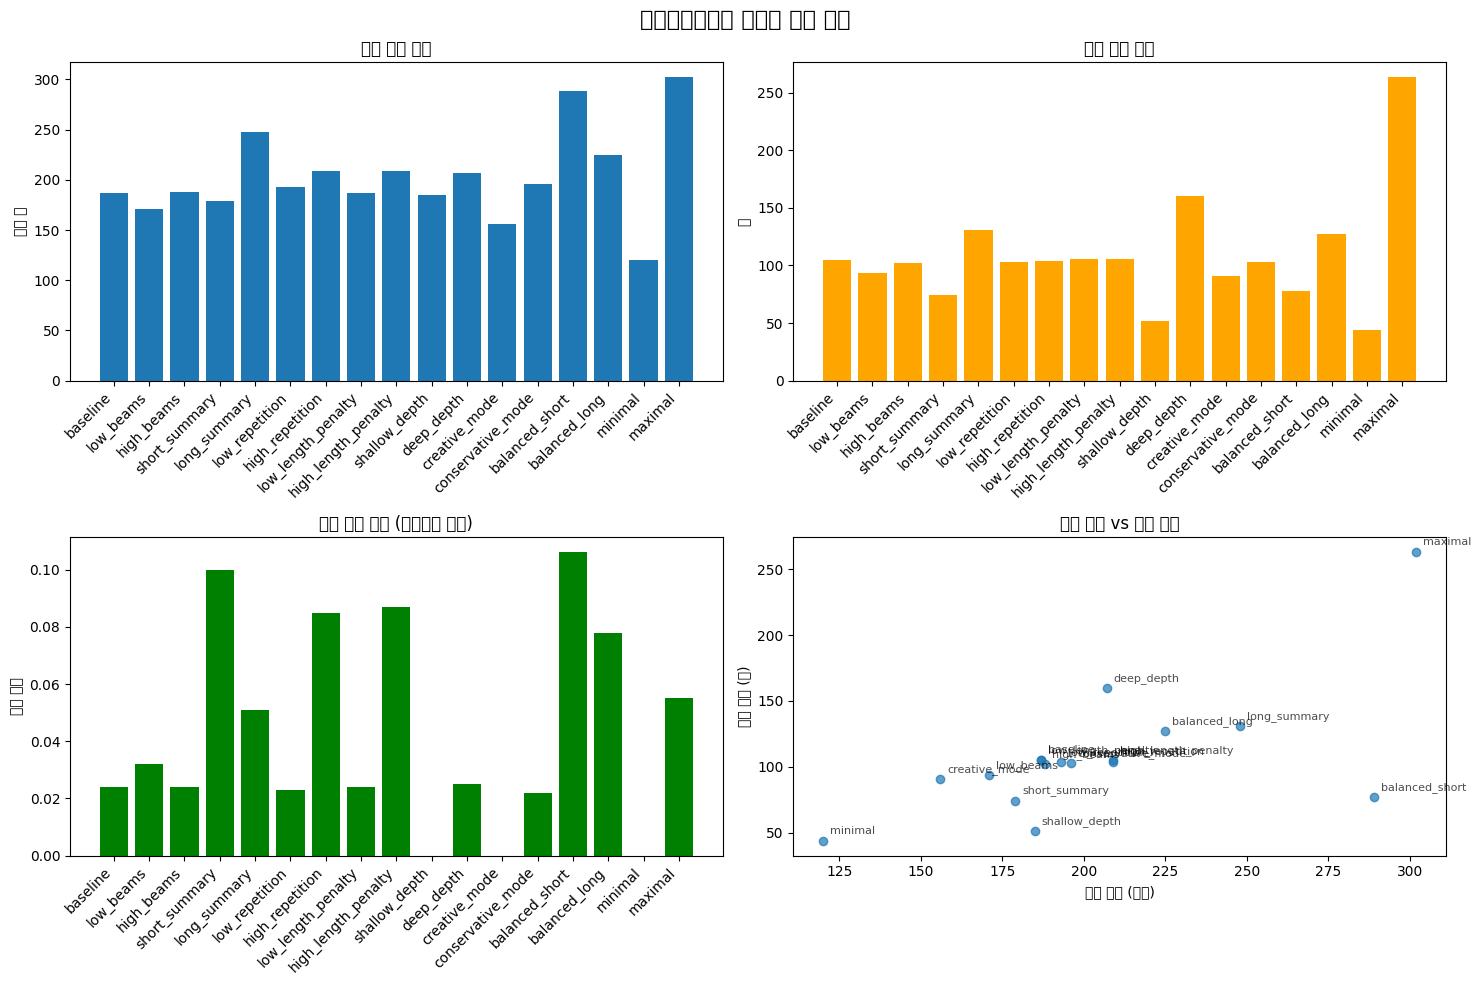

✅ 시각화 완료! (hyperparameter_test_visualization.png)
✅ 4단계 완료!

📋 5단계: JSON 데이터 저장
✅ 5단계 완료!

🎯 최종 실행 결과 요약

✅ 성공한 단계 (6개):
  ✅ 하이퍼파라미터 테스트
  ✅ 텍스트 결과 저장
  ✅ HTML 결과 저장
  ✅ 분석 보고서 생성
  ✅ 시각화 생성
  ✅ JSON 데이터 저장

📁 생성된 파일 확인:
사용 가능한 파일:
  ✅ 📄 텍스트 상세 결과
  ✅ 🌐 HTML 비교 결과
  ✅ 📊 분석 보고서
  ✅ 📈 시각화
  ✅ 💾 원본 데이터

💡 권장사항:
  🌐 HTML 파일을 브라우저에서 열어 인터랙티브한 결과를 확인하세요!

📊 전체 성공률: 100.0% (6/6)
🎉 대부분의 분석이 성공적으로 완료되었습니다!


In [17]:
if __name__ == "__main__":
    # PDF 파일 경로 확인
    pdf_path = "/content/test.pdf"

    if not os.path.exists(pdf_path):
        print(f"⚠️ 경고: {pdf_path} 파일이 없습니다.")
        print("테스트용 더미 파일을 생성하거나 올바른 경로를 지정해주세요.")

        # 더미 PDF 생성 (선택사항)
        create_dummy = input("더미 PDF 파일을 생성하시겠습니까? (y/n): ")
        if create_dummy.lower() == 'y':
            # 간단한 더미 PDF 생성
            import fitz
            doc = fitz.open()
            page = doc.new_page()
            text = """
            이것은 텍스트 요약 테스트를 위한 샘플 문서입니다.

            인공지능 기술의 발전으로 자연어 처리 분야에서 많은 혁신이 일어나고 있습니다.
            특히 텍스트 요약 기술은 정보 과부하 시대에 매우 중요한 기술로 주목받고 있습니다.

            자동 요약 시스템은 크게 추출적 요약과 추상적 요약으로 나뉩니다.
            추출적 요약은 원문에서 중요한 문장들을 선택하여 요약을 만드는 방식이고,
            추상적 요약은 원문의 내용을 이해하고 새로운 문장으로 요약을 생성하는 방식입니다.

            최근에는 트랜스포머 기반의 모델들이 뛰어난 성능을 보이고 있으며,
            특히 BART, T5 같은 모델들이 한국어 요약에서도 좋은 결과를 보여주고 있습니다.

            하이퍼파라미터 튜닝은 모델의 성능을 최적화하는 데 매우 중요한 과정입니다.
            beam search의 크기, 최대 길이, 반복 패널티 등 다양한 파라미터들이
            요약의 품질과 특성에 큰 영향을 미칩니다.
            """
            page.insert_text((50, 50), text)
            doc.save(pdf_path)
            doc.close()
            print(f"✅ 더미 PDF 파일 생성 완료: {pdf_path}")

    # 테스터 실행
    tester = HyperparameterTester(pdf_path='/content/test.pdf')
    tester.run_complete_analysis()